# English processing use cases
This notebook aims to test the Task and Object identification in patents in english.

1. **Task:** the method used in the described patent. In can be compress something or agilize a effect, for example.
2. **Object:** the "target" of the task. It can be a food, a construction material or any other object that, combined with the task, defines the patent.

It is supposed that NLP techniques are more refined to english data as the models are well-developed and to validate this theory, all the patents will be translated to english to them be processed.

[DL-Translate](https://pypi.org/project/dl-translate/), a Python library that implements a low verbosity use of many open source models to translation tasks.

Three models can be used to translate from portuguese to english:
- [mBART-50 Large](https://huggingface.co/transformers/master/model_doc/mbart.html): Allows translations across 50 languages.
- [m2m100](https://huggingface.co/docs/transformers/model_doc/m2m_100): Allows translations across 100 languages.
- [nllb-200](https://huggingface.co/docs/transformers/model_doc/nllb): Allows translations across 200 languages, and is faster than m2m100 (On RTX A6000, we can see speed up of 3x).

## Testing the models

To test the models we will evaluate using [FLORES+](https://huggingface.co/datasets/openlanguagedata/flores_plus) from Meta

In [1]:
import dl_translate as dlt

In [2]:
mt = dlt.TranslationModel(model_or_path="m2m100", device="gpu") 
text_pt = "A raposa é um animal muito esperto."
mt.translate(text_pt, source=dlt.lang.PORTUGUESE, target=dlt.lang.ENGLISH)

'The rabbit is a very intelligent animal.'

In [3]:
import huggingface_hub
huggingface_hub.login() # now you will be prompted to enter your token; enter it.

In [18]:
from datasets import load_dataset

In [19]:
ds_por = load_dataset("openlanguagedata/flores_plus", "por_Latn")
ds_por_df = ds_por['dev'].to_pandas()
ds_por_df.head()

Resolving data files:   0%|          | 0/219 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/213 [00:00<?, ?it/s]

,id,iso_639_3,iso_15924,glottocode,text,url,domain,topic,has_image,has_hyperlink,last_updated
0,0,por,Latn,braz1246,"Na segunda-feira, cientistas da Escola de Medi...",https://en.wikinews.org/wiki/Scientists_say_ne...,wikinews,health,yes,yes,1.0
1,1,por,Latn,braz1246,Os principais pesquisadores dizem que isso pod...,https://en.wikinews.org/wiki/Scientists_say_ne...,wikinews,health,yes,yes,1.0
2,2,por,Latn,braz1246,O JAS 39 Gripen se chocou com a pista por volt...,https://en.wikinews.org/wiki/Fighter_jet_crash...,wikinews,accident,yes,yes,1.0
3,3,por,Latn,braz1246,O piloto foi identificado como o Líder de Esqu...,https://en.wikinews.org/wiki/Fighter_jet_crash...,wikinews,accident,yes,yes,1.0
4,4,por,Latn,braz1246,A mídia local informa o capotamento de um veíc...,https://en.wikinews.org/wiki/Fighter_jet_crash...,wikinews,accident,yes,yes,1.0


In [20]:
ds_en = load_dataset("openlanguagedata/flores_plus", "eng_Latn")
ds_en_df = ds_en['dev'].to_pandas()
ds_en_df.head()

Resolving data files:   0%|          | 0/219 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/213 [00:00<?, ?it/s]

,id,iso_639_3,iso_15924,glottocode,text,url,domain,topic,has_image,has_hyperlink,last_updated
0,0,eng,Latn,stan1293,"On Monday, scientists from the Stanford Univer...",https://en.wikinews.org/wiki/Scientists_say_ne...,wikinews,health,yes,yes,1.0
1,1,eng,Latn,stan1293,Lead researchers say this may bring early dete...,https://en.wikinews.org/wiki/Scientists_say_ne...,wikinews,health,yes,yes,1.0
2,2,eng,Latn,stan1293,The JAS 39C Gripen crashed onto a runway at ar...,https://en.wikinews.org/wiki/Fighter_jet_crash...,wikinews,accident,yes,yes,1.0
3,3,eng,Latn,stan1293,The pilot was identified as Squadron Leader Di...,https://en.wikinews.org/wiki/Fighter_jet_crash...,wikinews,accident,yes,yes,1.0
4,4,eng,Latn,stan1293,Local media reports an airport fire vehicle ro...,https://en.wikinews.org/wiki/Fighter_jet_crash...,wikinews,accident,yes,yes,1.0


In [24]:
id = 0
print(f"English: {ds_en_df.loc[ds_en_df['id'] == id]['text'].values[0]}")
print(f"Portuguese: {ds_por_df.loc[ds_por_df['id'] == id]['text'].values[0]}")

English: On Monday, scientists from the Stanford University School of Medicine announced the invention of a new diagnostic tool that can sort cells by type: a tiny printable chip that can be manufactured using standard inkjet printers for possibly about one U.S. cent each.
Portuguese: Na segunda-feira, cientistas da Escola de Medicina da Universidade de Stanford anunciaram a invenção de uma nova ferramenta de diagnóstico que pode classificar células por tipo: um minúsculo chip imprimível que pode ser fabricado usando impressoras jato de tinta padrão por possivelmente cerca de um centavo de dólar cada.


In [ ]:
df_merged = ds_por_df[['id', 'text']].merge(
    ds_en_df[['id', 'text']],
    on='id',
    suffixes=('_pt', '_en')
)

df_merged.head()

,id,text_pt,text_en
0,0,"Na segunda-feira, cientistas da Escola de Medi...","On Monday, scientists from the Stanford Univer..."
1,1,Os principais pesquisadores dizem que isso pod...,Lead researchers say this may bring early dete...
2,2,O JAS 39 Gripen se chocou com a pista por volt...,The JAS 39C Gripen crashed onto a runway at ar...
3,3,O piloto foi identificado como o Líder de Esqu...,The pilot was identified as Squadron Leader Di...
4,4,A mídia local informa o capotamento de um veíc...,Local media reports an airport fire vehicle ro...


In [27]:
len(df_merged)

997

In [28]:
from tqdm import tqdm

tqdm.pandas()

df_merged["m2m100_translation"] = df_merged["text_pt"].progress_apply(
    lambda x: mt.translate(x, source=dlt.lang.PORTUGUESE, target=dlt.lang.ENGLISH)
)

df_merged.head()

100%|██████████| 997/997 [09:17<00:00,  1.79it/s]


,id,text_pt,text_en,m2m100_translation
0,0,"Na segunda-feira, cientistas da Escola de Medi...","On Monday, scientists from the Stanford Univer...","On Monday, scientists from the University of S..."
1,1,Os principais pesquisadores dizem que isso pod...,Lead researchers say this may bring early dete...,Lead researchers say that this can lead to ear...
2,2,O JAS 39 Gripen se chocou com a pista por volt...,The JAS 39C Gripen crashed onto a runway at ar...,The JAS 39 Gripen shocked with the track aroun...
3,3,O piloto foi identificado como o Líder de Esqu...,The pilot was identified as Squadron Leader Di...,The pilot was identified as the Squad Leader D...
4,4,A mídia local informa o capotamento de um veíc...,Local media reports an airport fire vehicle ro...,The local media the capture of a fire vehicle ...


In [30]:
df_merged.to_csv("../../data/processed/translation_benchmark_flores_plus_pt_en.csv", index=False)

In [ ]:
# Traduzindo os textos em português para inglês usando o modelo mbart50
mt_mbart50 = dlt.TranslationModel(model_or_path="mbart50", device="gpu")
df_merged["mbart50_translation"] = df_merged["text_pt"].progress_apply(
    lambda x: mt_mbart50.translate(x, source=dlt.lang.PORTUGUESE, target=dlt.lang.ENGLISH)
)

df_merged.to_csv("../../data/processed/translation_benchmark_flores_plus_pt_en.csv", index=False)

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]

100%|██████████| 997/997 [10:34<00:00,  1.57it/s]


OSError: Cannot save file into a non-existent directory: '../data/processed'

In [36]:
# # Traduzindo os textos em português para inglês usando o modelo nllb-200
# mt_nllb200 = dlt.TranslationModel(model_or_path="facebook/nllb-200-distilled-600M", device="gpu")
# df_merged["nllb200_translation"] = df_merged["text_pt"].progress_apply(
#     lambda x: mt_nllb200.translate(x, source=dlt.lang.PORTUGUESE, target=dlt.lang.ENGLISH)
# )

# df_merged.to_csv("../../data/processed/translation_benchmark_flores_plus_pt_en.csv", index=False)

In [37]:
df_merged.head()

,id,text_pt,text_en,m2m100_translation,mbart50_translation
0,0,"Na segunda-feira, cientistas da Escola de Medi...","On Monday, scientists from the Stanford Univer...","On Monday, scientists from the University of S...","On Monday, scientists at Stanford Medical Scho..."
1,1,Os principais pesquisadores dizem que isso pod...,Lead researchers say this may bring early dete...,Lead researchers say that this can lead to ear...,Leading researchers say this can lead to early...
2,2,O JAS 39 Gripen se chocou com a pista por volt...,The JAS 39C Gripen crashed onto a runway at ar...,The JAS 39 Gripen shocked with the track aroun...,JAS 39 Gripen slammed into the runway at about...
3,3,O piloto foi identificado como o Líder de Esqu...,The pilot was identified as Squadron Leader Di...,The pilot was identified as the Squad Leader D...,The pilot was identified as Commander-in-Chief...
4,4,A mídia local informa o capotamento de um veíc...,Local media reports an airport fire vehicle ro...,The local media the capture of a fire vehicle ...,The local media reports a helicopter capsize f...


In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calc_bleu(reference, hypothesis):
    smoothie = SmoothingFunction().method4
    return sentence_bleu([reference.split()], hypothesis.split(), smoothing_function=smoothie)

df_merged["bleu_m2m100"] = df_merged.apply(
    lambda row: calc_bleu(row["text_en"], row["m2m100_translation"]), axis=1
)

# Calculando BLEU para mbart50_translation
df_merged["bleu_mbart50"] = df_merged.apply(
    lambda row: calc_bleu(row["text_en"], row["mbart50_translation"]), axis=1
)

df_merged[["text_en", "m2m100_translation", "mbart50_translation", "bleu_m2m100", "bleu_mbart50"]].head()

,text_en,m2m100_translation,mbart50_translation,bleu_m2m100,bleu_mbart50
0,"On Monday, scientists from the Stanford Univer...","On Monday, scientists from the University of S...","On Monday, scientists at Stanford Medical Scho...",0.608199,0.462046
1,Lead researchers say this may bring early dete...,Lead researchers say that this can lead to ear...,Leading researchers say this can lead to early...,0.285757,0.222648
2,The JAS 39C Gripen crashed onto a runway at ar...,The JAS 39 Gripen shocked with the track aroun...,JAS 39 Gripen slammed into the runway at about...,0.413621,0.059216
3,The pilot was identified as Squadron Leader Di...,The pilot was identified as the Squad Leader D...,The pilot was identified as Commander-in-Chief...,0.525382,0.524736
4,Local media reports an airport fire vehicle ro...,The local media the capture of a fire vehicle ...,The local media reports a helicopter capsize f...,0.045999,0.052841


In [43]:
df_merged.to_csv("../../data/processed/translation_benchmark_flores_plus_pt_en.csv", index=False)

([<matplotlib.axis.XTick at 0x7c3c79c2bb30>,
 [Text(0, 0, 'm2m100'), Text(1, 0, 'mbart50')])

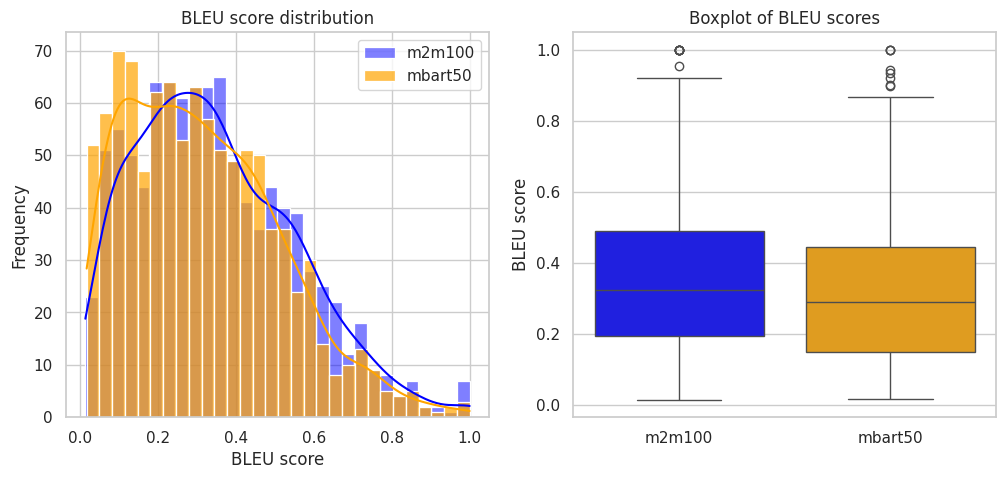

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df_merged["bleu_m2m100"], bins=30, color="blue", kde=True, label="m2m100")
sns.histplot(df_merged["bleu_mbart50"], bins=30, color="orange", kde=True, label="mbart50", alpha=0.7)
plt.title("BLEU score distribution")
plt.xlabel("BLEU score")
plt.ylabel("Frequency")
plt.legend()

# Boxplot comparativo
plt.subplot(1, 2, 2)
sns.boxplot(data=df_merged[["bleu_m2m100", "bleu_mbart50"]], palette=["blue", "orange"])
plt.title("Boxplot of BLEU scores")
plt.ylabel("BLEU score")
plt.xticks([0, 1], ["m2m100", "mbart50"])